In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

# Path to your SDF file
sdf_file = 'data/combined_mols_0_to_1000000.sdf'

# Load the SDF file as a supplier object
suppl = Chem.SDMolSupplier(sdf_file)

# Loop through the supplier object and work with molecules
for mol in suppl:
    if mol is not None:  # Check if the molecule is successfully loaded
        print(Chem.MolToSmiles(mol)) 
        break

ModuleNotFoundError: No module named 'pandas'

In [1]:
from rdkit import Chem
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')   

# Path to your SDF file
sdf_file = 'data/combined_mols_0_to_1000000.sdf'

# Create an SDMolSupplier object to read the SDF file
supplier = Chem.SDMolSupplier(sdf_file)

def is_valid_molecule(mol):
    """Check if all hydrogen atoms have exactly one bond."""
    total = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'H':
            total += 1
            if atom.GetDegree() != 1:
                return False
        if atom.GetSymbol() != 'H' and atom.GetDegree() == 1:
            return False
    return total > 1

molecule_list = []

# Iterate through each molecule in the SDF file
total_printed = 0
for index, mol in enumerate(supplier):
    if index % 100000 == 0:
        print(f'{index} / {len(supplier)}')
    
    if mol is not None and is_valid_molecule(mol):  # Check if the molecule is successfully read
        hydrogen_atoms_info = []
        other_atoms_info = []
        
        conf = mol.GetConformer()
        for atom in mol.GetAtoms():
            pos = conf.GetAtomPosition(atom.GetIdx())  # Get current atom position
            if atom.GetSymbol() == 'H':
                # For hydrogen atoms, find the atoms they are connected to
                for neighbor in atom.GetNeighbors():
                    neighbor_pos = conf.GetAtomPosition(neighbor.GetIdx())
                    hydrogen_atoms_info.append({
                        "H_position": (pos.x, pos.y, pos.z),
                        "connected_atom_type": neighbor.GetSymbol(),
                        "connected_atom_position": (neighbor_pos.x, neighbor_pos.y, neighbor_pos.z)
                    })
            else:
                # For other atoms, simply record their position
                other_atoms_info.append({
                    "atom_type": atom.GetSymbol(),
                    "position": (pos.x, pos.y, pos.z)
                })
                
        molecule_list.append({
            'H': hydrogen_atoms_info,
            'Other': other_atoms_info
        })
        
        print(hydrogen_atoms_info)


0 / 1000000
100000 / 1000000
[{'H_position': (2.4848, 1.9546, -0.1699), 'connected_atom_type': 'N', 'connected_atom_position': (3.1422, 1.1633, -0.1779)}, {'H_position': (6.0285, -2.1335, -1.8783), 'connected_atom_type': 'N', 'connected_atom_position': (5.7881, -2.898, -1.2329)}]
200000 / 1000000
[{'H_position': (3.3488, 3.1978, -1.6072), 'connected_atom_type': 'N', 'connected_atom_position': (2.6032, 3.6429, -1.0689)}, {'H_position': (-2.2282, 4.3897, 1.861), 'connected_atom_type': 'N', 'connected_atom_position': (-1.4752, 3.933, 1.3427)}]
300000 / 1000000
[{'H_position': (-0.1023, -0.3474, -0.3552), 'connected_atom_type': 'C', 'connected_atom_position': (0.8429, -0.0252, 0.0659)}, {'H_position': (3.2812, -0.8964, -1.0761), 'connected_atom_type': 'Si', 'connected_atom_position': (2.5468, -0.087, -0.015)}]
[{'H_position': (2.7244, 0.3878, -2.0758), 'connected_atom_type': 'N', 'connected_atom_position': (3.4981, 0.367, -1.4107)}, {'H_position': (4.9185, -3.3791, 0.7986), 'connected_atom

In [2]:
import numpy as np
import numpy.linalg as la

def molecule_to_np(hydrogen_list):
    n = len(hydrogen_list)
    
    h_q = np.zeros((3, n))
    h_p = np.zeros((3, n))
    n_q = np.zeros((3, n))
    h_l = np.zeros(n)
    h_m = np.zeros(n)
    
    for i, atom in enumerate(hydrogen_list):
        h_q[:, i] = np.array(atom['H_position'])
        n_q[:, i] = np.array(atom['connected_atom_position'])
        h_l[i] = np.linalg.norm(h_q[:, i] - n_q[:, i])
        h_m[i] = 1
        
        
    print(h_q, '\n', h_p, '\n', n_q)
    return h_q, h_p, n_q, h_l, h_m

h_q, h_p, n_q, h_l, h_m = molecule_to_np(molecule_list[10]['H'])

[[ 0.6726  4.8793]
 [ 0.2915 -0.5961]
 [-1.8353 -0.1572]] 
 [[0. 0.]
 [0. 0.]
 [0. 0.]] 
 [[ 0.2148  4.5022]
 [ 0.2589 -0.4224]
 [-0.9206 -1.0968]]


In [3]:
# Constants
k_spr = 0.1
eps = 1
sigma = 1

def kinetic_energy(h_p, h_m):
    ke = np.sum(np.sum(h_p**2, axis=0) / (2 * h_m))  
    return ke

def potential_energy(h_q, n_q, h_l, f_c, f_i):
    energy = 0
    k = h_q.shape[1]  # Number of particles
    for i in range(k):
        for j in range(i + 1, k):
            r_ij = np.linalg.norm(h_q[:, i] - h_q[:, j])
            energy += f_c(r_ij)
        r_i = np.linalg.norm(h_q[:, i] - n_q[:, i])
        l = h_l[i]
        energy += f_i(r_i, l)
    return energy

def v_t(q, t, e_t):
    return np.sum(e_t(t) * q)

def f_i(x, l):
    return -k_spr*(x - l)**2

def df_i(x, l):
    return -k_spr*2*(x - l)

def f_c(x):
    return -4*eps*((sigma/x)**12 - (sigma/x)**6) 

def df_c(x):
    return 4*eps*(12*sigma**12/x**13 - 6*sigma**6/x**7)

def e(t):
    return 0 # Consider conservative system initially

def H(h_p, h_q, n_q, h_m, h_l, f_c, f_i, e_t, t):
    return kinetic_energy(h_p, h_m) + potential_energy(h_q, n_q, h_l, f_c, f_i) + v_t(h_q, t, e_t)

def dH_dp_i(h_p, h_m, i):
    return h_p[:, i] / h_m[i]

def dH_dq_i(h_q, h_m, n_q, h_l, i):
    d, k = h_q.shape
    total = np.zeros(d)
    for j in range(k):
        if i == j:
            continue
        x = h_q[:, i] - h_q[:, j]
        norm_x = la.norm(x)
        total += x/norm_x * df_c(norm_x)
    x = h_q[:, i] - n_q[:, i]
    norm_x = la.norm(x)
    total += x / norm_x * df_i(norm_x, h_l[i])
    return total

def dH_dp(h_p, h_m):
    d, k = h_p.shape
    diff_p = np.zeros_like(h_p)
    for i in range(k):
        diff_p[:, i] = dH_dp_i(h_p, h_m, i)
    return diff_p

def dH_dq(h_q, h_m, n_q, h_l):
    d, k = h_q.shape
    diff_q = np.zeros_like(h_q)
    for i in range(k):
        diff_q[:, i] = dH_dq_i(h_q, h_m, n_q, h_l, i)
    return diff_q
    
    

In [4]:

def leapfrog_integration(q0, p0, n_q, h_l, m, dt, total_time):
    """
    Perform leapfrog integration.
    """
    steps = int(total_time / dt)
    q, p = q0.copy(), p0.copy()
    
    # Initialize arrays to store trajectories for plotting
    trajectories = np.zeros((q.shape[0], q.shape[1], steps + 1))
    trajectories[:, :, 0] = q
    
    momentums = np.zeros((p.shape[0], p.shape[1], steps + 1))
    momentums[:, :, 0] = p
    
    for step in range(steps):
        p_half = p - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        q = q + dt * dH_dp(p_half, m)
        p = p_half - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        
        # Store positions for plotting
        trajectories[:, :, step + 1] = q
        momentums[:, :, step + 1] = p
    
    return trajectories, momentums

In [7]:

dt = 0.001
total_time = 200*np.pi 

trajectories, momentums = leapfrog_integration(h_q, h_p, n_q, h_l, h_m, dt, total_time)

/tmp/ipykernel_779/2366797081.py:35: RuntimeWarning: overflow encountered in scalar power
  return 4*eps*(12*sigma**12/x**13 - 6*sigma**6/x**7)


(3, 2, 628319)


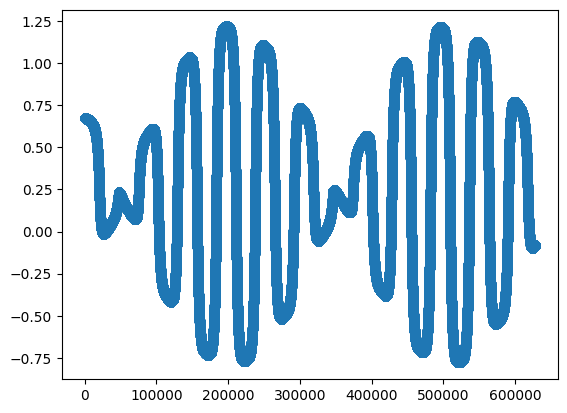

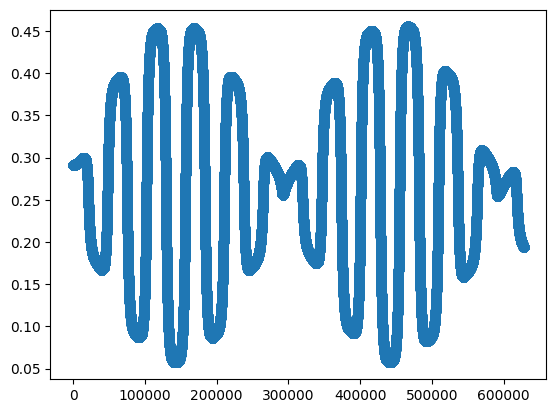

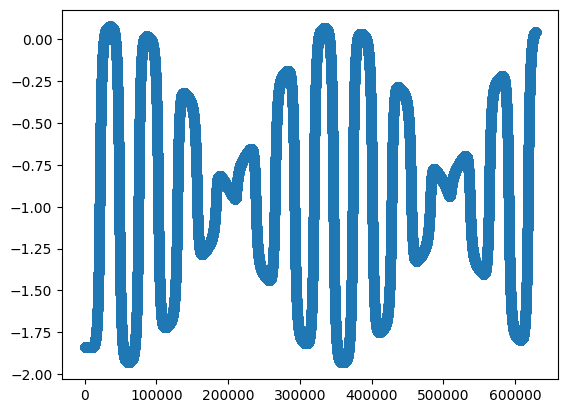

In [8]:
import matplotlib.pyplot as plt
print(trajectories.shape)
plt.scatter(list(range(trajectories.shape[2])), trajectories[0, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[1, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[2, 0, :])
plt.show()

(3, 2, 628319)


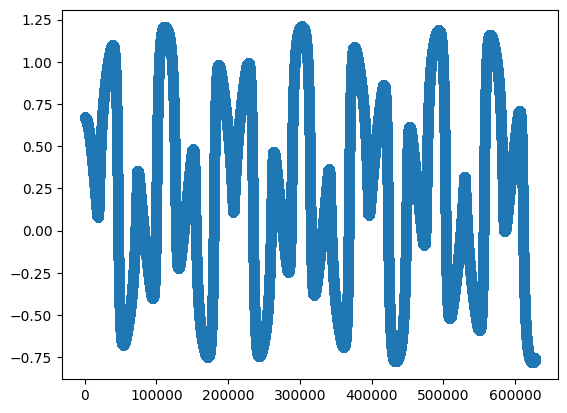

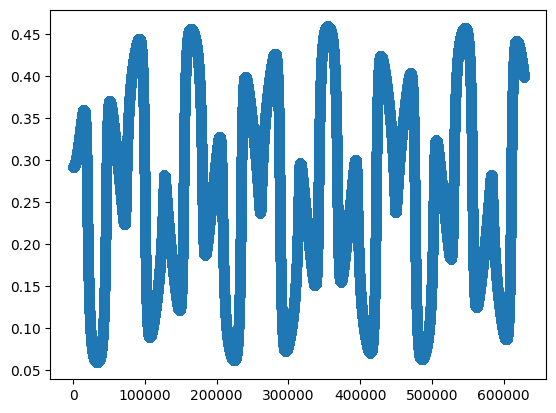

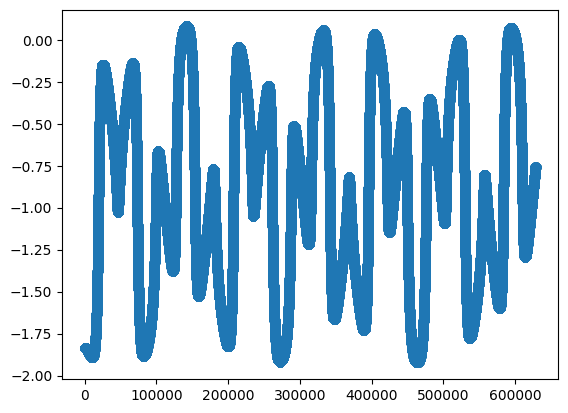

In [113]:
import matplotlib.pyplot as plt
print(trajectories.shape)
plt.scatter(list(range(trajectories.shape[2])), trajectories[0, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[1, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[2, 0, :])
plt.show()

In [128]:
import torch

# Constants
k_spr = 0.1
eps = 1
sigma = 1

def kinetic_energy(h_p, h_m):
    ke = torch.sum(torch.sum(h_p**2, dim=0) / (2 * h_m))
    return ke

def potential_energy(h_q, n_q, h_l, f_c, f_i):
    energy = 0
    k = h_q.shape[1]  # Number of particles
    for i in range(k):
        for j in range(i + 1, k):
            r_ij = torch.norm(h_q[:, i] - h_q[:, j], p=2)
            energy += f_c(r_ij)
        r_i = torch.norm(h_q[:, i] - n_q[:, i], p=2)
        l = h_l[i]
        energy += f_i(r_i, l)
    return energy

def v_t(q, t, e_t):
    return torch.sum(e_t(t) * q)

def f_i(x, l):
    return -k_spr * (x - l) ** 2

def f_c(x):
    return -4 * eps * ((sigma / x) ** 12 - (sigma / x) ** 6)

def e(t):
    return 0  # Consider conservative system initially

def H(h_p, h_q, n_q, h_m, h_l, f_c, f_i, e_t, t):
    return kinetic_energy(h_p, h_m) + potential_energy(h_q, n_q, h_l, f_c, f_i) + v_t(h_q, t, e_t)

# Example usage
# Assuming h_p, h_q, n_q, h_m, h_l are PyTorch tensors with requires_grad=True if gradients are needed

# Example tensor initialization (replace with actual values as needed)
d, k = 3, 2  # dimensions, number of particles
# h_p = torch.randn(d, k, requires_grad=True)
# h_q = torch.randn(d, k, requires_grad=True)
# n_q = torch.randn(d, k, requires_grad=True)
# h_m = torch.tensor([1.0, 1.0], requires_grad=True)
# h_l = torch.tensor([1.0, 1.0], requires_grad=True)
th_p = torch.tensor(h_p, requires_grad=True)# + torch.randn(d, k, requires_grad=True) / 10
th_q = torch.tensor(h_q, requires_grad=True)# + torch.randn(d, k, requires_grad=True) / 10
tn_q = torch.tensor(n_q, requires_grad=False)
th_m = torch.tensor(h_m, requires_grad=False)
th_l = torch.tensor(h_l, requires_grad=False)

# Compute Hamiltonian
hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)

# Compute gradients
# hamiltonian.backward()

# # Access gradients
# print(th_p.grad)
# print(th_q.grad)
# print(hamiltonian)

# print(torch.autograd.grad(hamiltonian, th_p, retain_graph=True))
# print(torch.autograd.grad(hamiltonian, [th_p, th_q], retain_graph=True))


In [33]:

print(dH_dp(h_p, h_m))

print(dH_dq(h_q, h_m, n_q, h_l))

print(th_p.grad)

print(th_q.grad)
    

[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[-10101748.46351608  10101748.46351608]
 [  2131436.02734135  -2131436.02734135]
 [ -4029701.21392691   4029701.21392691]]
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)
tensor([[-10101748.4635,  10101748.4635],
        [  2131436.0273,  -2131436.0273],
        [ -4029701.2139,   4029701.2139]], dtype=torch.float64)


In [125]:

def torch_leapfrog_integration(tq0, tp0, tn_q, th_l, th_m, dt, total_time):
    """
    Perform leapfrog integration.
    """
    steps = int(total_time / dt)
    th_q, th_p = tq0.clone().detach().requires_grad_(True), tp0.clone().detach().requires_grad_(True)
    
    hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
    
    # Initialize arrays to store trajectories for plotting
    trajectories = torch.zeros((th_q.shape[0], th_q.shape[1], steps + 1), requires_grad=False)
    trajectories[:, :, 0] = th_q.clone().detach()
    
    momentums = torch.zeros((th_p.shape[0], th_p.shape[1], steps + 1), requires_grad=False)
    momentums[:, :, 0] = th_p.clone().detach()
    
    for step in range(steps):
        if step % (steps // 10) == 0:
            print(f'Step {step} out of {steps}')
        hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        # hamiltonian.backward()
        # p_half = (th_p - 0.5 * dt * th_p.grad).clone().detach().requires_grad_(True)
        
        # th_p.grad = None
        # p_half.grad = None
        # th_q.grad = None 
        # p_half = p - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        # q = q + dt * dH_dp(p_half, m)
        # p = p_half - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        
        th_q_grad = torch.autograd.grad(hamiltonian, th_q, retain_graph=True)[0]
        p_half = (th_p - 0.5 * dt * th_q_grad).clone().detach().requires_grad_(True)
        # th_p_grad_old = dH_dp(th_p.detach().numpy(), th_m.detach().numpy())
        
        hamiltonian = H(p_half, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        # hamiltonian.backward()
        # th_q = (th_q + dt * p_half.grad).clone().detach().requires_grad_(True)
        
        # th_p.grad = None
        # p_half.grad = None
        # th_q.grad = None
        p_half_grad = torch.autograd.grad(hamiltonian, p_half, retain_graph=True)[0]
        th_q = (th_q + dt * p_half_grad).clone().detach().requires_grad_(True)
        
        hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        # hamiltonian.backward()
        # th_p = (p_half - 0.5 * dt * th_q.grad).clone().detach().requires_grad_(True)
        
        # th_p.grad = None
        # p_half.grad = None
        # th_q.grad = None
        th_q_grad = torch.autograd.grad(hamiltonian, th_q, retain_graph=True)[0]
        th_p = (p_half - 0.5 * dt * th_q_grad).clone().detach().requires_grad_(True)
        
        # th_q_grad_old = dH_dq(th_q.detach().numpy(), th_m.detach().numpy(), tn_q.detach().numpy(), th_l.detach().numpy())
        # if not (abs(torch.norm(th_q_grad) - np.linalg.norm(th_q_grad_old)) > 0.001 or abs(torch.norm(th_p_grad) - np.linalg.norm(th_p_grad_old)) > 0.001):
        #     print(th_q_grad)
        #     print(th_q_grad_old)
        #     print(th_p_grad)
        #     print(th_p_grad_old)
        #     print()
        
        # Store positions for plotting
        trajectories[:, :, step + 1] = th_q.clone().detach()
        momentums[:, :, step + 1] = th_p.clone().detach()
    
    return trajectories, momentums

In [129]:

dt = 0.001
total_time = 200*np.pi 

trajectories, momentums = torch_leapfrog_integration(th_q, th_p, tn_q, th_l, th_m, dt, total_time)
# torch_leapfrog_integration(th_q, th_p, tn_q, th_l, th_m, dt, total_time)

Step 0 out of 628318
Step 62831 out of 628318
Step 125662 out of 628318
Step 188493 out of 628318
Step 251324 out of 628318
Step 314155 out of 628318
Step 376986 out of 628318
Step 439817 out of 628318
Step 502648 out of 628318
Step 565479 out of 628318
Step 628310 out of 628318


torch.Size([3, 2, 628319])


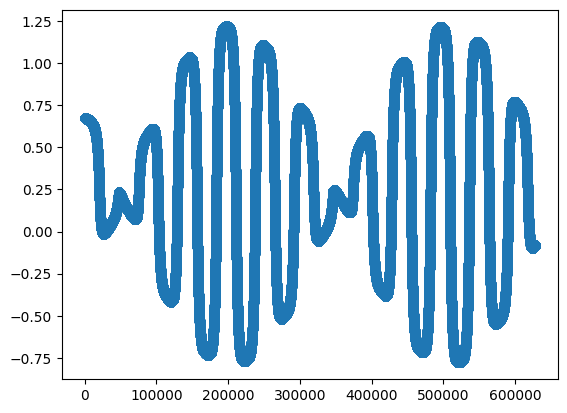

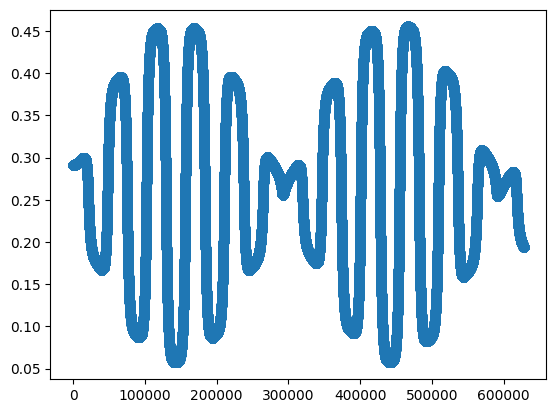

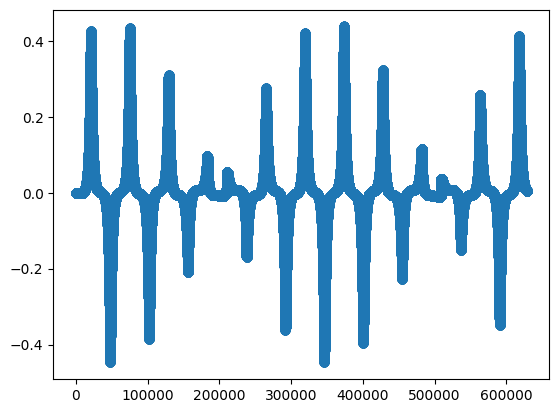

In [130]:
import matplotlib.pyplot as plt
print(trajectories.shape)
plt.scatter(list(range(trajectories.shape[2])), trajectories[0, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[1, 0, :])
plt.show()

plt.scatter(list(range(momentums.shape[2])), momentums[2, 0, :])
plt.show()